# Software Engineering for Economists

## Background

Software Engineering is an important component of *Scientific Computing*. It encompasses the tools and methods for defining requirements for designing, programming, testing, and managing software. It is crucial to ensure that the computational implementation is a faithful representation of the orginal mathmatical model (Oberkampf & Roy, 2013)

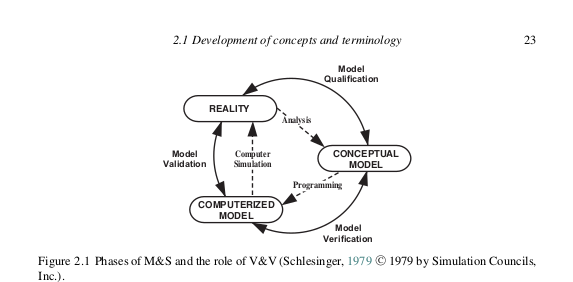

In [1]:
from IPython.display import Image
Image(filename='images/conceptual_model.png', width=1000)

*Software Engineering* is part of the verification step, i.e. the substantiation that the computerized model represents a conceptual model within specified limits of accuracy (Schlesinger, 1979). For those interested in structural microeconometrics, we were lucky enough to have [Prof. Keane](http://www.economics.ox.ac.uk/Academic/michael-keane) talk about the process of devloping, estimating, and validating in the [*Computation Economics Colloquium*](http://bfi.uchicago.edu/events/computational-economics-colloquium). The video of his presentation is available [online](http://bfi.uchicago.edu/video/practical-issues-structural-estimation).

We look at a selected components of a sound software engineering workflow.

* Version Control

* Testing

* Code Review

* Profiling

* Continous Integration Workflow

See Bourque & Fairley (2014) for an extensive list.

## Running Example

Throughout this lecture we will work with a simple example from expected utility theory. We consider a simple utility function that captures an agent's preferences over uncertain outcomes.

$$ u(x) = x^\alpha,$$

where $\alpha, x > 0$. We can calculate the expected utility (EU) as:

$$E U= \int^{-\infty}_{\infty} u(x) f(x),$$

where $f(x)$ is the probablity density function of the realizations of $x$. In our case, $x$ is drawn from a lognormal distribution with mean $\mu$ and standard deviation $\sigma$. To solve the integral, we implement a simple Monte Carlo Iitegration. See Judd & Skrainka (2013) for an illustration of the importance of integration strategies.

In [2]:
# SciPy Stack
import numpy as np


def get_expected_utility(alpha, mean, sd):
    """ Get the expected returns by drawing numerous
    random deviates from a lognormal distribution.
    """
    # Guard interface
    assert (isinstance(mean, float))
    assert (isinstance(sd, float))
    assert (isinstance(alpha, float))
    assert (sd >= 0.00)
    assert (alpha >= 0.00)
    
    # Set parametrization for Monte Carlo 
    # integration.
    num_draws = 10000000
    
    # Draw ten-thousand deviates from the 
    deviates = get_random_deviates(mean, sd, num_draws)
    
    # Calculate the average utility from all deviates.
    rslt = np.mean(deviates ** alpha)
    
    # Check result
    assert (isinstance(rslt, float))
        
    # Finishing
    return rslt


def get_random_deviates(mean, sd, num_draws):
    """ Get random deviates from a lognormal 
    distribution.
    """
    # Draw deviates from lognormal distribution.
    deviates = []
    for _ in range(num_draws):
        deviate = np.random.lognormal(mean, sd)
        deviates += [deviate]
    
    # Type Conversion
    deviates = np.array(deviates)
    
    # Finishing
    return deviates

## Version Control

## Testing

In [3]:
def generate_random_request():
    """ Generate a random admissible request.
    """
    # Draw random deviates that honor the suppert
    # constraints.
    mean = np.random.normal()
    alpha, sd = np.random.uniform(size=2)

    # Finishing
    return alpha, mean, sd

So let us check whether our function runs for some admissible values.

In [4]:
# Generate and evaluate a random request.
alpha, mean, sd = generate_random_request()
rslt = get_expected_utility(alpha, mean, sd)
# Print out request and result
print('Request: {0:.3f}, {1:.3f}, {2:.3f}  Result: {3:.3f}'.format(alpha, mean, sd, rslt))

Request: 0.590, -0.099, 0.409  Result: 0.971


Let us define some basic tests that partly embody some of our previous knowledge about the result.

In [5]:
def test_random_requests():
    """ Draw a whole host of random requests to 
    ensure that the function works for all admissible 
    values.
    """    
    for _ in range(5):
        # Get expected returns.
        alpha, mean, sd = generate_random_request()
        get_expected_utility(alpha, mean, sd)


def test_results():
    """ Test some previous knowledge about the results.
    """
    for _ in range(5):
        # Get expected returns.
        alpha, mean, sd = generate_random_request()
        rslt = get_expected_utility(alpha, mean, sd)
        # Assertions
        assert rslt > 0   


def test_closed_form():
    """ Test the simulated result against the closed 
    form solution in the special case of linear utility.
    """
    for _ in range(1):
        _, mean, sd = generate_random_request()
        alpha = 1.0
        # Get expected returns using simulation.
        simulated = get_expected_utility(alpha, mean, sd)
        # Get expected returns using closed form.
        closed = np.exp(mean + (sd ** 2) * 0.5)
        # Assertions. Note the small number of decimal points
        # required. Given the precision of the Monte Carlo integration
        # this test if bound to fail sometimes.
        np.testing.assert_almost_equal(closed, simulated, decimal=3)

In principle, we can now run our tests one-by-one.

In [6]:
test_random_requests()

test_results()

test_closed_form()

How about test automation? Let us now run our test battery in the terminal. See our repository [here](https://github.com/softEcon/talks/blob/master/ZICE/software_engineering/tests.py) for the script. We are using [*py.test*](http://pytest.org). As usual, several alternatives exist: (1) [*nose*](https://nose.readthedocs.org/en/latest/), (2) [unittest](https://docs.python.org/2/library/unittest.html#module-unittest).

In [7]:
%%bash
py.test tests.py --verbose 

================================================================================================================================ test session starts ================================================================================================================================
platform linux2 -- Python 2.7.10, pytest-2.8.5, py-1.4.31, pluggy-0.3.1 -- /home/peisenha/.envs/softEcon/bin/python
cachedir: .cache
rootdir: /home/peisenha/Dropbox/@office/teaching/lectures/softEcon/talks/ZICE/software_engineering, inifile: 
plugins: cov-2.2.0
collecting ... collected 3 items

tests.py::test_random_requests PASSED
tests.py::test_results PASSED
tests.py::test_closed_form FAILED

===================================================================================================================================== FAILURES ======================================================================================================================================
_____________________________________________

How do we know how much of our code base we in fact cover with our testing efforts so far?

In [8]:
%%bash
py.test tests.py --cov=sandbox

================================================================================================================================ test session starts ================================================================================================================================
platform linux2 -- Python 2.7.10, pytest-2.8.5, py-1.4.31, pluggy-0.3.1
rootdir: /home/peisenha/Dropbox/@office/teaching/lectures/softEcon/talks/ZICE/software_engineering, inifile: 
plugins: cov-2.2.0
collected 3 items

tests.py ..F

===================================================================================================================================== FAILURES ======================================================================================================================================
_________________________________________________________________________________________________________________________________ test_closed_form _______________________________________________________________

To see these basic ideas in action, let us check out the testing harness for my current research project [online](https://github.com/robustToolbox/package/tree/master/development/tests).

## Code Review

There are several tools out there that I found useful in the past: (1) [*QuantifiedCode*](https://www.quantifiedcode.com/) and (2) [*Codacy*](https://www.codacy.com). Let us visit *QuantifiedCode* online and take a look around.

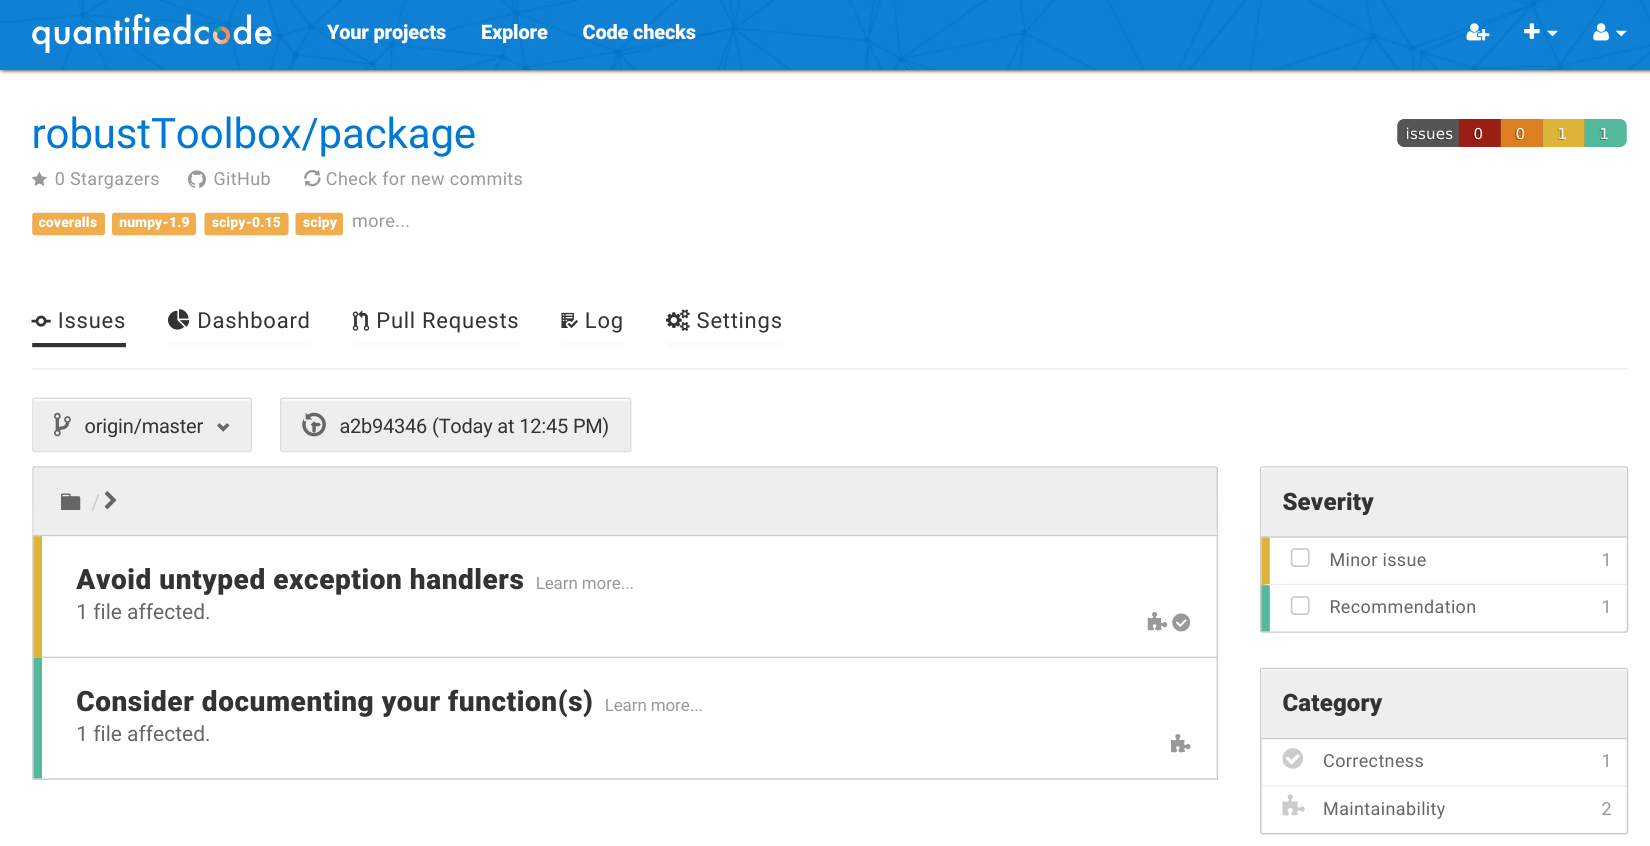

In [9]:
from IPython.display import Image
Image(filename='images/quantifiedcode.png')

## Profiling

Now that we have a well designed and tested version of our code, it is time to look for potential improvements in execution speed.

In [10]:
%load_ext snakeviz

In [11]:
# standard library
import cProfile

import sandbox
from sandbox import get_expected_utility

# As a start, let us start with a table of profile data.
cProfile.run("get_expected_utility(1.0, 0.0, 1.0)")

         100021 function calls in 0.112 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.001    0.001    0.112    0.112 <string>:1(<module>)
        1    0.000    0.000    0.000    0.000 _methods.py:43(_count_reduce_items)
        1    0.000    0.000    0.000    0.000 _methods.py:53(_mean)
        1    0.000    0.000    0.000    0.000 fromnumeric.py:2785(mean)
        1    0.000    0.000    0.000    0.000 numeric.py:476(asanyarray)
        1    0.062    0.062    0.106    0.106 sandbox.py:40(get_random_deviates)
        1    0.001    0.001    0.111    0.111 sandbox.py:8(get_expected_utility)
        1    0.000    0.000    0.000    0.000 {hasattr}
        6    0.000    0.000    0.000    0.000 {isinstance}
        1    0.000    0.000    0.000    0.000 {issubclass}
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}
   100000    0.041    0.000    0.041    0.000 {method 'l

We build on the [SNAKEVIZ](http://jiffyclub.github.io/snakeviz/) tool.

In [12]:
cProfile.run("get_expected_utility(1.0, 0.0, 1.0)", "sandbox.prof")

In [13]:
%%bash
snakeviz sandbox.prof

Process is interrupted.


As it turns out, most of the time is spend to draw the random deviates from the lognormal distribution. So, we just target some development time.

In [14]:
%time rslt = get_expected_utility(1.0, 0.0, 1.0, version='slow')
print('')
%time rslt = get_expected_utility(1.0, 0.0, 1.0, version='fast')

CPU times: user 60 ms, sys: 8 ms, total: 68 ms
Wall time: 67.6 ms

CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 9.19 ms


Let us also store and visualize the profiling table.

In [15]:
cProfile.run("get_expected_utility(1.0, 0.0, 1.0, 'fast')", "sandbox_fast.prof")

In [16]:
%%bash
snakeviz sandbox_fast.prof

Process is interrupted.


## Continuous Integration Workflow

easy of workflow ...

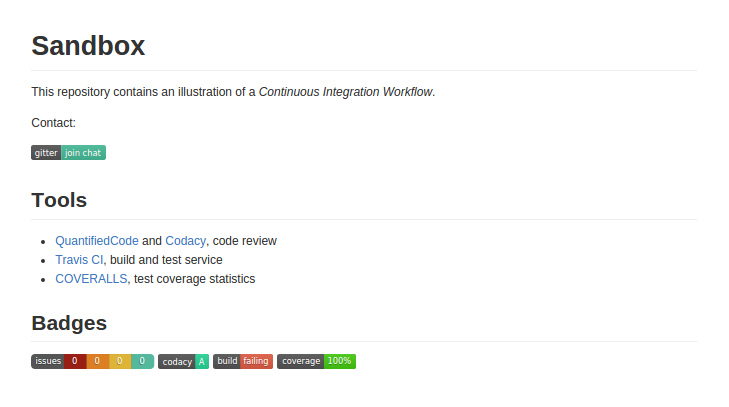

In [17]:
from IPython.display import Image
Image(filename='images/continous_integration.png', width=1000, height=1000)

## Action Steps

## References

* Oberkampf, W. L., Roy, C. J. (2013). *Verifcation and Validation and Scientific Computing*. Cambridge University Press, Cambridge, England.

* Schlesinger, S. (1979). Terminology for Model Credibility. *Simulation*. 32(3), 103–104.

* Skrainka, B, Judd, K. J. (2011). *High Performance Quadrature Rules: How Numerical Integration Affects a Popular Model of Product Differentiation*. Working Paper. 

* Wilson G, Aruliah DA, Brown CT, Chue Hong NP, Davis M, Guy RT, et al. (2014). *Best Practices for Scientific Computing*. PLOS Biology 12(1).

* P. Bourque and R.E. Fairley, eds. (2014). *Guide to the Software Engineering Body of Knowledge*. IEEE Computer Society.


***Formatting***

In [18]:
import urllib; from IPython.core.display import HTML
HTML(urllib.urlopen('http://bit.ly/1K5apRH').read())